In [2]:
import pandas as pd
import numpy as np
import xgboost as xgb
from sklearn.model_selection import train_test_split
from sklearn.metrics import classification_report, accuracy_score, confusion_matrix, roc_auc_score, roc_curve
import matplotlib.pyplot as plt
import seaborn as sns

# Import Data

In [3]:
df = pd.read_csv('Flight_delay.csv')

In [4]:
df.head()

,DayOfWeek,Date,DepTime,ArrTime,CRSArrTime,UniqueCarrier,Airline,FlightNum,TailNum,ActualElapsedTime,...,TaxiIn,TaxiOut,Cancelled,CancellationCode,Diverted,CarrierDelay,WeatherDelay,NASDelay,SecurityDelay,LateAircraftDelay
0,4,03-01-2019,1829,1959,1925.0,WN,Southwest Airlines Co.,3920.0,N464WN,90.0,...,3.0,10.0,0.0,N,0.0,2.0,0.0,0.0,0.0,32.0
1,4,03-01-2019,1937,2037,1940.0,WN,Southwest Airlines Co.,509.0,N763SW,240.0,...,3.0,7.0,0.0,N,0.0,10.0,0.0,0.0,0.0,47.0
2,4,03-01-2019,1644,1845,1725.0,WN,Southwest Airlines Co.,1333.0,N334SW,121.0,...,6.0,8.0,0.0,N,0.0,8.0,0.0,0.0,0.0,72.0
3,4,03-01-2019,1452,1640,1625.0,WN,Southwest Airlines Co.,675.0,N286WN,228.0,...,7.0,8.0,0.0,N,0.0,3.0,0.0,0.0,0.0,12.0
4,4,03-01-2019,1323,1526,1510.0,WN,Southwest Airlines Co.,4.0,N674AA,123.0,...,4.0,9.0,0.0,N,0.0,0.0,0.0,0.0,0.0,16.0


# Select Columns

In [5]:
df = df[['DayOfWeek','Date','DepTime','Airline','Origin','Dest','CarrierDelay']]
df

,DayOfWeek,Date,DepTime,Airline,Origin,Dest,CarrierDelay
0,4,03-01-2019,1829,Southwest Airlines Co.,IND,BWI,2.0
1,4,03-01-2019,1937,Southwest Airlines Co.,IND,LAS,10.0
2,4,03-01-2019,1644,Southwest Airlines Co.,IND,MCO,8.0
3,4,03-01-2019,1452,Southwest Airlines Co.,IND,PHX,3.0
4,4,03-01-2019,1323,Southwest Airlines Co.,IND,TPA,0.0
...,...,...,...,...,...,...,...
27914,2,29-01-2019,1915,Skywest Airlines Inc.,DFW,SLC,0.0
27915,2,29-01-2019,2156,Skywest Airlines Inc.,SLC,SFO,39.0
27916,2,29-01-2019,1931,Skywest Airlines Inc.,LAX,SLC,0.0
27917,2,29-01-2019,1744,Skywest Airlines Inc.,SLC,LAX,0.0


# Check for missing data

In [6]:
df.isnull().sum()

,0
DayOfWeek,0
Date,0
DepTime,0
Airline,1
Origin,1
Dest,1
CarrierDelay,1


# Convert Date Column to Pandas Datetime

In [7]:
df['Date'] = pd.to_datetime(df['Date'], dayfirst=True)

# Create Month And Day Feature

In [8]:
df['month'] = df['Date'].dt.month
df['day'] = df['Date'].dt.day

### Drop Date now

In [9]:

# Drop the original 'Date' column since XGBoost doesn't handle datetime types
df = df.drop(columns=['Date'])

# Identify Categorical variables

In [10]:
categories = df.select_dtypes(include=['object']).columns
categories

Index(['Airline', 'Origin', 'Dest'], dtype='object')

# One-Hot Encoding (Dummy Variables) for Categorical Data

In [11]:
df_encoded = pd.get_dummies(df, drop_first=True)

# Prepare Target Variable(s)

In [12]:
df_encoded['is_delayed_60+'] = np.where(df_encoded['CarrierDelay'] > 60, 1, 0)
# df_encoded['is_delayed_15+'] = np.where(df_encoded['CarrierDelay'] > 30, 1, 0)
df_encoded

,DayOfWeek,DepTime,CarrierDelay,month,day,Airline_Southwest Airlines Co.,Origin_ABQ,Origin_ACV,Origin_ALB,Origin_AMA,...,Dest_TPA,Dest_TUL,Dest_TUS,Dest_TVC,Dest_TWF,Dest_TYS,Dest_XNA,Dest_YKM,Dest_YUM,is_delayed_60+
0,4,1829,2.0,1,3,True,False,False,False,False,...,False,False,False,False,False,False,False,False,False,0
1,4,1937,10.0,1,3,True,False,False,False,False,...,False,False,False,False,False,False,False,False,False,0
2,4,1644,8.0,1,3,True,False,False,False,False,...,False,False,False,False,False,False,False,False,False,0
3,4,1452,3.0,1,3,True,False,False,False,False,...,False,False,False,False,False,False,False,False,False,0
4,4,1323,0.0,1,3,True,False,False,False,False,...,True,False,False,False,False,False,False,False,False,0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
27914,2,1915,0.0,1,29,False,False,False,False,False,...,False,False,False,False,False,False,False,False,False,0
27915,2,2156,39.0,1,29,False,False,False,False,False,...,False,False,False,False,False,False,False,False,False,0
27916,2,1931,0.0,1,29,False,False,False,False,False,...,False,False,False,False,False,False,False,False,False,0
27917,2,1744,0.0,1,29,False,False,False,False,False,...,False,False,False,False,False,False,False,False,False,0


# Define features and target variable


In [13]:
X = df_encoded.drop(columns=['is_delayed_60+', 'CarrierDelay'])
y = df_encoded['is_delayed_60+']

In [14]:
X

,DayOfWeek,DepTime,month,day,Airline_Southwest Airlines Co.,Origin_ABQ,Origin_ACV,Origin_ALB,Origin_AMA,Origin_ASE,...,Dest_SYR,Dest_TPA,Dest_TUL,Dest_TUS,Dest_TVC,Dest_TWF,Dest_TYS,Dest_XNA,Dest_YKM,Dest_YUM
0,4,1829,1,3,True,False,False,False,False,False,...,False,False,False,False,False,False,False,False,False,False
1,4,1937,1,3,True,False,False,False,False,False,...,False,False,False,False,False,False,False,False,False,False
2,4,1644,1,3,True,False,False,False,False,False,...,False,False,False,False,False,False,False,False,False,False
3,4,1452,1,3,True,False,False,False,False,False,...,False,False,False,False,False,False,False,False,False,False
4,4,1323,1,3,True,False,False,False,False,False,...,False,True,False,False,False,False,False,False,False,False
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
27914,2,1915,1,29,False,False,False,False,False,False,...,False,False,False,False,False,False,False,False,False,False
27915,2,2156,1,29,False,False,False,False,False,False,...,False,False,False,False,False,False,False,False,False,False
27916,2,1931,1,29,False,False,False,False,False,False,...,False,False,False,False,False,False,False,False,False,False
27917,2,1744,1,29,False,False,False,False,False,False,...,False,False,False,False,False,False,False,False,False,False


# Split the data into training and testing sets

In [15]:
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.3, random_state=0)

# LightGBM with Optuna - Handling Imbalanced with SMOTE + LGBM Class Weight


In [17]:
# LightGBM + Optuna + SMOTE for Imbalanced Classification
import lightgbm as lgb
import optuna
from sklearn.model_selection import cross_val_score
from sklearn.metrics import roc_auc_score, classification_report
from imblearn.over_sampling import SMOTE

# Apply SMOTE on Training Data Only
print("Before SMOTE:", y_train.value_counts(normalize=True))
smote = SMOTE(random_state=42)
X_train_res, y_train_res = smote.fit_resample(X_train, y_train)
print("After SMOTE:", y_train_res.value_counts(normalize=True))

# Objective Function for Optuna
def objective_lgb(trial):
    params = {
        'objective': 'binary',
        'metric': 'auc',
        'boosting_type': 'gbdt',
        'verbosity': -1,
        'learning_rate': trial.suggest_float('learning_rate', 0.01, 0.2, log=True),
        'num_leaves': trial.suggest_int('num_leaves', 20, 150),
        'max_depth': trial.suggest_int('max_depth', 3, 10),
        'min_child_samples': trial.suggest_int('min_child_samples', 10, 100),
        'subsample': trial.suggest_float('subsample', 0.5, 1.0),
        'colsample_bytree': trial.suggest_float('colsample_bytree', 0.5, 1.0),
        'reg_alpha': trial.suggest_float('reg_alpha', 1e-3, 10.0, log=True),
        'reg_lambda': trial.suggest_float('reg_lambda', 1e-3, 10.0, log=True),
        'class_weight': 'balanced',  # still keep balanced weights
        'random_state': 42
    }

    model = lgb.LGBMClassifier(**params)
    auc = cross_val_score(model, X_train_res, y_train_res, cv=3, scoring='roc_auc', n_jobs=-1).mean()
    return auc

# Run Optuna Optimization
study_lgb = optuna.create_study(direction='maximize', study_name='LightGBM_SMOTE')
study_lgb.optimize(objective_lgb, n_trials=30, show_progress_bar=True)

print("\nBest LightGBM Parameters:")
print(study_lgb.best_trial.params)

# Train Final Model with Best Parameters
best_params_lgb = study_lgb.best_trial.params
best_params_lgb['class_weight'] = 'balanced'

lgb_model = lgb.LGBMClassifier(**best_params_lgb)
lgb_model.fit(X_train_res, y_train_res)

# Evaluate Performance
y_pred_proba_lgb = lgb_model.predict_proba(X_test)[:, 1]
auc_lgb = roc_auc_score(y_test, y_pred_proba_lgb)

print(f"\nFinal LightGBM ROC-AUC: {auc_lgb:.4f}")

y_pred_lgb = lgb_model.predict(X_test)
print("\nClassification Report:\n", classification_report(y_test, y_pred_lgb))


Before SMOTE: is_delayed_60+
0    0.935783
1    0.064217
Name: proportion, dtype: float64


[I 2025-11-06 16:51:25,009] A new study created in memory with name: LightGBM_SMOTE


After SMOTE: is_delayed_60+
0    0.5
1    0.5
Name: proportion, dtype: float64


  0%|          | 0/30 [00:00<?, ?it/s]

[I 2025-11-06 16:51:33,288] Trial 0 finished with value: 0.9650264001048837 and parameters: {'learning_rate': 0.027146791727876245, 'num_leaves': 58, 'max_depth': 9, 'min_child_samples': 39, 'subsample': 0.9641987589893528, 'colsample_bytree': 0.5528909147351455, 'reg_alpha': 0.005147511830682126, 'reg_lambda': 0.01205788454036871}. Best is trial 0 with value: 0.9650264001048837.
[I 2025-11-06 16:51:35,341] Trial 1 finished with value: 0.9656002779887505 and parameters: {'learning_rate': 0.18934885966421205, 'num_leaves': 112, 'max_depth': 4, 'min_child_samples': 32, 'subsample': 0.6462809177178804, 'colsample_bytree': 0.6981251403297966, 'reg_alpha': 4.905431855824883, 'reg_lambda': 0.0017060662395531716}. Best is trial 1 with value: 0.9656002779887505.
[I 2025-11-06 16:51:36,894] Trial 2 finished with value: 0.9604610758700683 and parameters: {'learning_rate': 0.04722484727295194, 'num_leaves': 20, 'max_depth': 8, 'min_child_samples': 25, 'subsample': 0.549757219889994, 'colsample_by

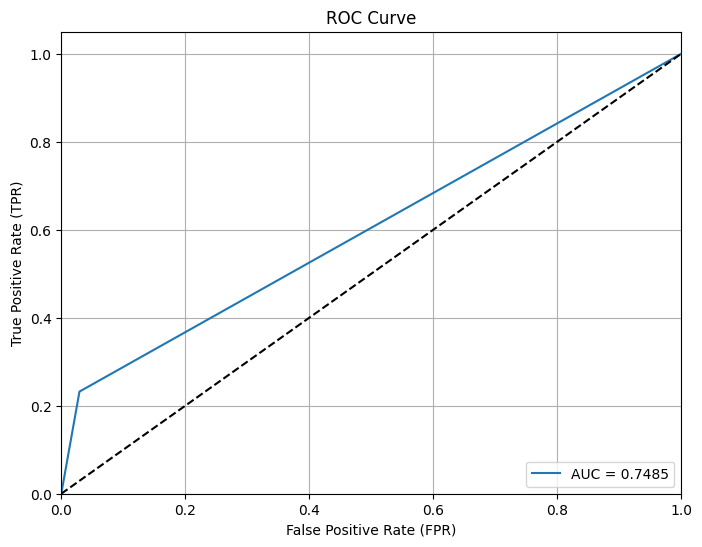

In [18]:
# Plot the ROC curve
fpr, tpr, thresholds = roc_curve(y_test, y_pred_lgb)
plt.figure(figsize=(8, 6))
plt.plot(fpr, tpr, label=f'AUC = {auc_lgb:.4f}')
plt.plot([0, 1], [0, 1], 'k--')  # Diagonal line for random guessing
plt.xlim([0.0, 1.0])
plt.ylim([0.0, 1.05])
plt.xlabel('False Positive Rate (FPR)')
plt.ylabel('True Positive Rate (TPR)')
plt.title('ROC Curve')
plt.legend(loc="lower right")
plt.grid(True)
plt.show()

# CatBoost with Optuna

In [ ]:
from catboost import CatBoostClassifier, Pool
import optuna
from sklearn.metrics import roc_auc_score
from sklearn.model_selection import cross_val_score
from imblearn.over_sampling import SMOTE

# Apply SMOTE on Training Data Only
print("Before SMOTE:", y_train.value_counts(normalize=True))
smote = SMOTE(random_state=42)
X_train_res, y_train_res = smote.fit_resample(X_train, y_train)
print("After SMOTE:", y_train_res.value_counts(normalize=True))

def objective_catboost(trial):
    params = {
        'iterations': trial.suggest_int('iterations', 300, 1000),
        'learning_rate': trial.suggest_float('learning_rate', 0.01, 0.2, log=True),
        'depth': trial.suggest_int('depth', 4, 10),
        'l2_leaf_reg': trial.suggest_float('l2_leaf_reg', 1e-2, 10.0, log=True),
        'bagging_temperature': trial.suggest_float('bagging_temperature', 0.0, 1.0),
        'border_count': trial.suggest_int('border_count', 32, 255),
        'random_strength': trial.suggest_float('random_strength', 0.1, 2.0),
        'leaf_estimation_iterations': trial.suggest_int('leaf_estimation_iterations', 1, 10),
        'loss_function': 'Logloss',
        'eval_metric': 'AUC',
        'verbose': False,
        'random_seed': 42
    }

    model = CatBoostClassifier(**params)

    # 3-fold cross-validation ROC-AUC
    auc = cross_val_score(model, X_train_res, y_train_res, cv=3, scoring='roc_auc', n_jobs=-1).mean()
    return auc

# Create study
study_cat = optuna.create_study(direction='maximize')
study_cat.optimize(objective_catboost, n_trials=30, show_progress_bar=True)

print("\nBest CatBoost Parameters:")
print(study_cat.best_trial.params)

# Train final CatBoost model
best_params_cat = study_cat.best_trial.params
cat_model = CatBoostClassifier(**best_params_cat)
cat_model.fit(X_train_res, y_train_res, verbose=False)

# Evaluate
y_pred_cat = cat_model.predict(X_test)
y_pred_proba_cat = cat_model.predict_proba(X_test)[:, 1]
auc_cat = roc_auc_score(y_test, y_pred_proba_cat)

print(f"\n Best CatBoost ROC-AUC on Test Set: {auc_cat:.4f}")


Before SMOTE: is_delayed_60+
0    0.935783
1    0.064217
Name: proportion, dtype: float64


[I 2025-11-06 16:53:24,103] A new study created in memory with name: no-name-b3a0e1ae-8fd9-42dc-8cce-ecca94f2f0f3


After SMOTE: is_delayed_60+
0    0.5
1    0.5
Name: proportion, dtype: float64


  0%|          | 0/30 [00:00<?, ?it/s]

[I 2025-11-06 16:54:16,477] Trial 0 finished with value: 0.9782150831662776 and parameters: {'iterations': 635, 'learning_rate': 0.04013212011509416, 'depth': 9, 'l2_leaf_reg': 1.5113045653556345, 'bagging_temperature': 0.9562386566169337, 'border_count': 103, 'random_strength': 0.42378602938228727, 'leaf_estimation_iterations': 2}. Best is trial 0 with value: 0.9782150831662776.
[I 2025-11-06 16:55:35,995] Trial 1 finished with value: 0.9812637948481916 and parameters: {'iterations': 746, 'learning_rate': 0.05470151858766307, 'depth': 10, 'l2_leaf_reg': 0.023793330657887413, 'bagging_temperature': 0.8504361386215951, 'border_count': 134, 'random_strength': 0.8231313118698452, 'leaf_estimation_iterations': 10}. Best is trial 1 with value: 0.9812637948481916.
[I 2025-11-06 16:56:09,534] Trial 2 finished with value: 0.9765840323057962 and parameters: {'iterations': 753, 'learning_rate': 0.02471193841735044, 'depth': 8, 'l2_leaf_reg': 0.01196898145094626, 'bagging_temperature': 0.21108529

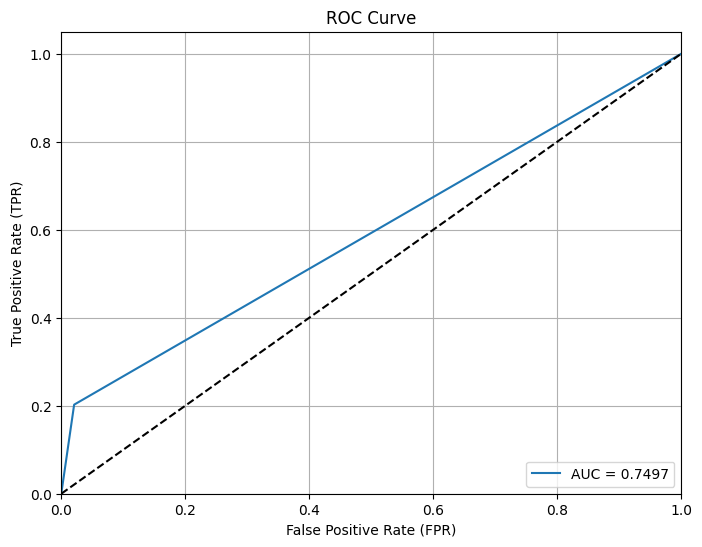

In [23]:
# Plot the ROC curve
fpr, tpr, thresholds = roc_curve(y_test, y_pred_cat)
plt.figure(figsize=(8, 6))
plt.plot(fpr, tpr, label=f'AUC = {auc_cat:.4f}')
plt.plot([0, 1], [0, 1], 'k--')  # Diagonal line for random guessing
plt.xlim([0.0, 1.0])
plt.ylim([0.0, 1.05])
plt.xlabel('False Positive Rate (FPR)')
plt.ylabel('True Positive Rate (TPR)')
plt.title('ROC Curve')
plt.legend(loc="lower right")
plt.grid(True)
plt.show()

# Compare LGBM and CatBoost

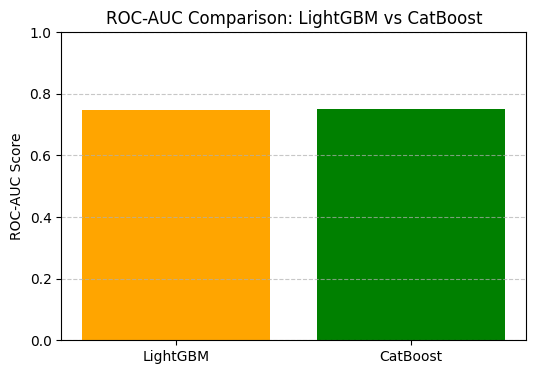

      Model   ROC-AUC
0  LightGBM  0.748509
1  CatBoost  0.749666


In [24]:
comparison_df = pd.DataFrame({
    "Model": ["LightGBM", "CatBoost"],
    "ROC-AUC": [auc_lgb, auc_cat]
})

plt.figure(figsize=(6,4))
plt.bar(comparison_df["Model"], comparison_df["ROC-AUC"], color=["orange", "green"])
plt.title("ROC-AUC Comparison: LightGBM vs CatBoost")
plt.ylabel("ROC-AUC Score")
plt.ylim(0, 1)
plt.grid(axis='y', linestyle='--', alpha=0.7)
plt.show()

print(comparison_df)